In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os,sys,glob, json
import _pickle as pkl
import dlab
from tqdm.notebook import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('dark_background')


In [2]:
import matplotlib 
matplotlib.rcParams.update({'figure.max_open_warning': 0})

In [3]:
recording_folder = '/Volumes/DATA7/grant/rotation/2023-09-29_16-07-39_PaBont2'
# recording_folder = '/Volumes/s2/Grant/rotation/2023-09-29_16-07-39_PaBont2'

experimenter = 'grh'
experiment_description= 'Denman Lab, University of Colorado Anschutz. Test of PaBoNT axon silencing of V1 axons'

# #spikeglx
# probes = [os.path.basename(f) for f in np.sort(glob.glob(recording_folder+'/*-AP*'))]

probeids = ['A','B','C'] 
probedepths = [1050,1050,3450] 

In [4]:
stim_path = '/Volumes/DATA7/grant/rotation/2023-09-29_16-07-39_PaBont2/stim'
gratings_pkl = pkl.load(open(glob.glob(stim_path+'/*gratings_o*')[0],'rb'))
gratings_pkl_o = pkl.load(open(glob.glob(stim_path+'/*gratings_o*')[1],'rb'))

scene_pkl = pkl.load(open(glob.glob(stim_path+'/*scene_f*')[0],'rb'))
scene_pkl_o = pkl.load(open(glob.glob(stim_path+'/*scene_f*')[1],'rb'))

image_start_frame = [int(start_frame) for start_frame,end_frame in scene_pkl['bgsweepframes']]
image_start_frame_o = [int(start_frame) for start_frame,end_frame in scene_pkl_o['bgsweepframes']]
image_order = scene_pkl['bgsweeporder']
image_order_o = scene_pkl_o['bgsweeporder']

In [5]:
from open_ephys.analysis import Session

directory = recording_folder # for example

session = Session(recording_folder)

In [6]:
events_df = pd.DataFrame(session.recordnodes[0].recordings[0].events)#

In [7]:
session.recordnodes[0].recordings[0].events

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
0,1,101492653,3386.402741,106,4,ProbeC-AP,0
1,1,8457752,3386.402776,106,3,ProbeB-LFP,0
2,1,101493035,3386.402875,106,2,ProbeB-AP,0
3,1,101492903,3386.402884,106,0,ProbeA-AP,0
4,8,101599890,3386.402900,107,6,PXI-6133,0
...,...,...,...,...,...,...,...
836186,1,25407903,10173.222491,106,3,ProbeB-LFP,0
836187,1,25407869,10173.222800,106,1,ProbeA-LFP,0
836188,1,304894840,10173.223351,106,2,ProbeB-AP,0
836189,1,304893672,10173.223528,106,4,ProbeC-AP,0


In [8]:
ni_df = events_df[events_df.stream_name == 'PXI-6133' ]

In [9]:
ni_df

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
4,8,101599890,3386.402900,107,6,PXI-6133,0
11,8,101614905,3386.903400,107,6,PXI-6133,1
15,8,101629920,3387.403900,107,6,PXI-6133,0
21,8,101644935,3387.904400,107,6,PXI-6133,1
28,8,101659950,3388.404900,107,6,PXI-6133,0
...,...,...,...,...,...,...,...
835904,5,304513227,10150.181461,107,6,PXI-6133,0
835917,5,304543254,10151.182361,107,6,PXI-6133,1
835930,5,304573724,10152.198028,107,6,PXI-6133,0
835947,5,304603885,10153.203394,107,6,PXI-6133,1


In [10]:
ni_ts = {}
df_up = ni_df[ni_df.state==1]
for ch in ni_df.line.unique():
    ni_ts[ch] = df_up[df_up.line == ch].timestamp

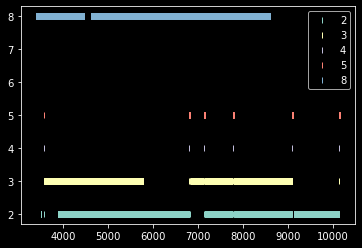

In [11]:
for ch in ([2,3,4,5,8]):
    plt.plot(np.array(ni_ts[ch]),
             np.ones(len(ni_ts[ch]))*ch,
             '|',label=ch)
plt.legend()
# plt.xlim(gratings_times.values[-1] -1, gratings_times.values[-1]+60)

In [12]:
# eye_camera_frame_times = ni_ts[7]
opto_df = ni_df[ni_df.line==5]
opto_off_times = opto_df[opto_df.state==0].timestamp
opto_on_times = opto_df[opto_df.state==1].timestamp

df_flash = ni_df[ni_df.line==3]
flash_times = df_flash[df_flash.state==1].timestamp[1:101]#first 100 are flash onset

arbMatrix_start_time = flash_times.values[-1]
df_strf = ni_df[ni_df.line==2]
arbMatrix_times = df_strf[df_strf.state==1].timestamp[df_strf[df_strf.state==1].timestamp > arbMatrix_start_time][:12000]

gratings_start_time = arbMatrix_times.values[-1]
df_gratings = ni_df[ni_df.line==2]
gratings_times = df_gratings[df_gratings.state==1].timestamp[df_gratings[df_gratings.state==1].timestamp > gratings_start_time][:640]

images_start_time = gratings_times.values[-1]
df_images = ni_df[ni_df.line==2]
images_times = df_images[df_images.state==1].timestamp[df_images[df_images.state==1].timestamp > images_start_time][:int(image_start_frame[-1])+1].values[image_start_frame]

df_flash_o = ni_df[ni_df.line==3]
flash_times_o = df_flash_o[df_flash_o.state==1].timestamp[df_flash_o[df_flash_o.state==1].timestamp > images_times[-1]][1:101]#first 100 are flash onset

arbMatrix_start_time_o = flash_times_o.values[-1]
df_strf_o = ni_df[ni_df.line==2]
arbMatrix_times_o = df_strf_o[df_strf_o.state==1].timestamp[df_strf_o[df_strf_o.state==1].timestamp > arbMatrix_start_time_o][:12000]

gratings_start_time_o = arbMatrix_times_o.values[-1]
df_gratings_o = ni_df[ni_df.line==2]
gratings_times_o = df_gratings_o[df_gratings_o.state==1].timestamp[df_gratings_o[df_gratings_o.state==1].timestamp > gratings_start_time_o][2:642]

images_start_time_o = gratings_times_o.values[-1]
df_images_o = ni_df[ni_df.line==2]
images_times_o = df_images_o[df_images_o.state==1].timestamp[df_images_o[df_images_o.state==1].timestamp > images_start_time_o][:int(image_start_frame_o[-1])+1].values[image_start_frame_o]




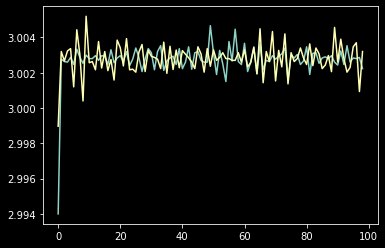

In [13]:
plt.plot(np.diff(flash_times))
plt.plot(np.diff(flash_times_o))

(0.0, 0.1)

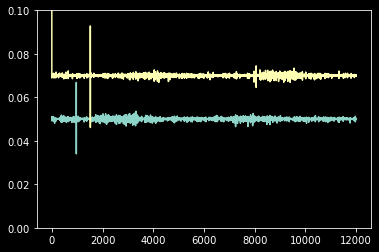

In [14]:
plt.plot(np.diff(arbMatrix_times))
plt.plot(np.diff(arbMatrix_times_o)+0.02)
plt.ylim(0,0.1)

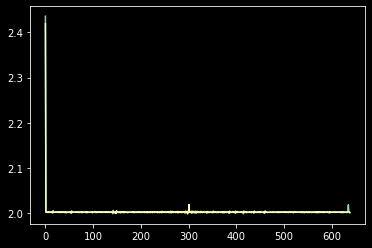

In [15]:
plt.plot(np.diff(gratings_times))
plt.plot(np.diff(gratings_times_o))
# plt.xlim(0,10)

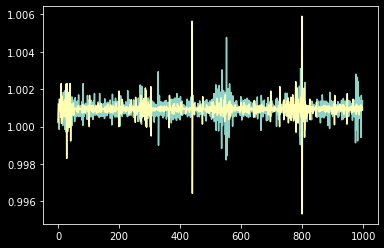

In [16]:
plt.plot(np.diff(images_times))
plt.plot(np.diff(images_times_o))
# plt.xlim(0,10)

In [17]:
stimuli_times = {'luminance_flash':flash_times,
                'spatioluminance_noise':arbMatrix_times,
                'gratings':gratings_times,
                'scenes':images_times,
                'luminance_flash_opto':flash_times_o,
                'spatioluminance_noise_opto':arbMatrix_times_o,
                'gratings_opto':gratings_times_o,
                'scenes_opto':images_times_o,
                  }

In [18]:
#finish loading the stimuli
arbMatrix_matrix = pkl.load(open(np.sort(glob.glob(stim_path+'/*'))[0],'rb'))
arbMatrix_matrix_o = pkl.load(open(np.sort(glob.glob(stim_path+'/*'))[1],'rb'))


#stimulus list
stimuli = {'luminance_flash':None,
            'spatioluminance_noise':arbMatrix_matrix,
            'gratings':gratings_pkl,
            'scenes':image_order,
            'luminance_flash_opto':None,
            'spatioluminance_noise_opto':arbMatrix_matrix_o,
            'gratings_opto':gratings_pkl_o,
            'scenes_opto':image_order_o,
           } 

## Assemble NWB

In [19]:
import pynwb
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.utils import StrDataset

In [20]:
from datetime import datetime
from dateutil.tz import tzlocal
from pynwb import NWBFile

nwbfile = NWBFile('Axon silencing with PaBoNT; PaBoNT_2', 
                  recording_folder, 
                  datetime.now(tzlocal()),
                  experimenter=experimenter,
                  lab='Denman Lab',
                  institution='University of Colorado',
                  experiment_description=experiment_description,
                  session_id=os.path.basename(recording_folder))

add stimulus information

In [21]:
for stim in stimuli_times.keys():
    nwbfile.add_epoch(np.array(stimuli_times[stim])[0], 
                      np.array(stimuli_times[stim])[-1]+3.,
                      [stim])

In [22]:
nwbfile.add_trial_column('stimulus', 'the stimulus during this trial')

#optogenetics
nwbfile.add_trial_column('optogenetics_LED_state',    'whether or not the LED was on or off for this trial. 1=on,0=off. exact opto times are available in optogenetics_states field of NWB')

#flashCSD
nwbfile.add_trial_column('flash_luminance', 'the luminance of the flash on this trial. 1=bright,0=dark')

#gratings_orientation
nwbfile.add_trial_column('contrast', 'index of each trial into a matrix of images')
nwbfile.add_trial_column('temporal_frequency', 'index of each trial into a matrix of images')
nwbfile.add_trial_column('spatial_frequency', 'index of each trial into a matrix of images')
nwbfile.add_trial_column('orientation', 'index of each trial into a matrix of images')

#arbMatrix and scene flicker
nwbfile.add_trial_column('stimulus_index', 'index of each trial into a matrix or list of images')

stim_vals = {'optogenetics_LED_state':-1,
             'flash_luminance':-1,
             'contrast':-1,
             'temporal_frequency':-1,
             'spatial_frequency':-1,
             'orientation':-1,
             'stimulus_index':-1,}

lums = [0,1]#['white','black']
stim = 'luminance_flash'
for i,trial_start in enumerate(np.array(stimuli_times[stim])):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,
                      flash_luminance=lums[i%2],
                      optogenetics_LED_state=0,
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      stimulus_index = stim_vals['stimulus_index'],
                     )
stim = 'luminance_flash_opto'
for i,trial_start in enumerate(np.array(stimuli_times[stim])):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,
                      flash_luminance=lums[i%2],
                      optogenetics_LED_state=1,
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      stimulus_index = stim_vals['stimulus_index'],
                     )

stim = 'spatioluminance_noise'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])),stimulus=stim,
                      flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index=i,
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      optogenetics_LED_state = 0)

stim = 'spatioluminance_noise_opto'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])),stimulus=stim,
                      flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index=i,
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      optogenetics_LED_state = 1)
stim = 'gratings'
info = [stimuli[stim]['bgsweeptable'][ind] for ind in stimuli[stim]['bgsweeporder']]
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,
                        flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index = stim_vals['stimulus_index'],
                      contrast=info[i][0],
                     temporal_frequency=info[i][2],
                     spatial_frequency=info[i][3],
                     orientation=info[i][-2],
                     optogenetics_LED_state=0)

stim = 'gratings_opto'
info = [stimuli[stim]['bgsweeptable'][ind] for ind in stimuli[stim]['bgsweeporder']]
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,
                        flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index = stim_vals['stimulus_index'],
                      contrast=info[i][0],
                     temporal_frequency=info[i][2],
                     spatial_frequency=info[i][3],
                     orientation=info[i][-2],
                     optogenetics_LED_state=1)
                     
stim = 'scenes'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])),stimulus=stim,
                      flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index=stimuli[stim][i],
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      optogenetics_LED_state = 0)

stim = 'scenes_opto'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])),stimulus=stim,
                      flash_luminance = stim_vals['flash_luminance'],
                      stimulus_index=stimuli[stim][i],
                      contrast = stim_vals['contrast'],
                     temporal_frequency = stim_vals['temporal_frequency'],
                     spatial_frequency = stim_vals['spatial_frequency'],
                     orientation = stim_vals['orientation'],
                      optogenetics_LED_state = 1)
    

In [23]:
df = nwbfile.trials.to_dataframe()

In [24]:
df

,start_time,stop_time,stimulus,optogenetics_LED_state,flash_luminance,contrast,temporal_frequency,spatial_frequency,orientation,stimulus_index
id,,,,,,,,,,
0,3570.826467,3573.829202,luminance_flash,0,0,-1,-1,-1.0,-1,-1
1,3573.820467,3576.823202,luminance_flash,0,1,-1,-1,-1.0,-1,-1
2,3576.823233,3579.825968,luminance_flash,0,0,-1,-1,-1.0,-1,-1
3,3579.825867,3582.828602,luminance_flash,0,1,-1,-1,-1.0,-1,-1
4,3582.828467,3585.831202,luminance_flash,0,0,-1,-1,-1.0,-1,-1
...,...,...,...,...,...,...,...,...,...,...
27475,10118.996425,10119.997369,scenes_opto,1,-1,-1,-1,-1.0,-1,15
27476,10119.997359,10120.998302,scenes_opto,1,-1,-1,-1,-1.0,-1,16
27477,10120.998259,10121.999202,scenes_opto,1,-1,-1,-1,-1.0,-1,17


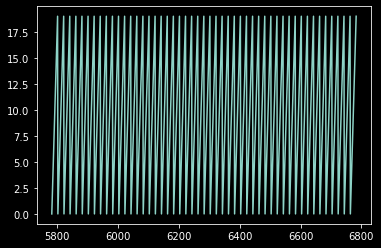

In [25]:
plt.plot(df[df.stimulus=='scenes'].start_time,df[df.stimulus=='scenes'].stimulus_index)

## add optogenetics

In [26]:
np.array(opto_off_times).shape[0]

77

In [27]:
opto_states = pynwb.epoch.TimeIntervals(
    name="optogenetics_states",
    description="intervals for optical fiber, fiber at power = 1.5AU on cyclops driver. fiber 565nm, ",
)
opto_states.add_column(name="power", description="power of fiber")
opto_states.add_column(name="wavelength", description="wavelength of light")

for i in range(np.array(opto_off_times).shape[0]):
    opto_states.add_row(start_time=np.array(opto_on_times)[i], stop_time=np.array(opto_off_times)[i], power=1.5, wavelength=565)

nwbfile.add_time_intervals(opto_states)

optogenetics_states pynwb.epoch.TimeIntervals at 0x140469116776912
Fields:
  colnames: ['start_time' 'stop_time' 'power' 'wavelength']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    power <class 'hdmf.common.table.VectorData'>,
    wavelength <class 'hdmf.common.table.VectorData'>
  )
  description: intervals for optical fiber, fiber at power = 1.5AU on cyclops driver. fiber 565nm, 
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

### add ephys data
first add electrodes and raw data link

In [28]:
from dlab.nwbtools import df_from_phy, load_phy_template, option234_positions, multi_load_unit_data


no Allen Institute NWB API. get this from http://stash.corp.alleninstitute.org/projects/INF/repos/ainwb/browse
no OpenEphys.py get this from https://github.com/open-ephys/analysis-tools


In [35]:
recording_folder = os.path.join('/Volumes/DATA7/grant/rotation/2023-09-29_16-07-39_PaBont2','Record Node 103','experiment1/recording1/continuous')

In [36]:
df_units = multi_load_unit_data(recording_folder,probe_depths=probedepths)

OSError: [Errno 30] Read-only file system: '/Volumes/DATA7/grant/rotation/2023-09-29_16-07-39_PaBont2/Record Node 103/experiment1/recording1/continuous/Neuropix-PXI-106.ProbeA-AP/spike_secs.npy'

In [113]:
locations = ['VISp','VISl','VISa;CA1;DG;LP']
descriptions = ['Neuropixels1.0','Neuropixels1.0','Neuropixels1.0'] 

In [114]:
device = nwbfile.create_device(name='DenmanLab_EphysRig1')

for i, probe in enumerate(probes):
    electrode_name = 'probe'+str(i)
    description = descriptions[i]
    location = locations[i]

    electrode_group = nwbfile.create_electrode_group(electrode_name,
                                                     description=description,
                                                     location=location,
                                                     device=device)
    for ch in range(option234_positions.shape[0]):
        nwbfile.add_electrode(x=option234_positions[ch,0],y=0.,z=option234_positions[0,1],imp=0.0,location='none',filtering='high pass 300Hz',group=electrode_group)
    
#     if len(glob.glob(os.path.join(recording_folder,probes[1])+'/*lf.b*')) > 0:
#         ephys_ts = pynwb.ecephys.ElectricalSeries('lfp_probe'+probeids[i],
#                                 data=H5DataIO(data=StrDataset(glob.glob(os.path.join(recording_folder,probes[1])+'/*lf.b*')[0]),    
#                                         link_data=True),
#                                 electrodes = electrode_group,
#                                 starting_time=0,
#                                 rate=2500,
#                                 resolution=0.001,
#                                 comments="V1, depth = 1500um",
#                                 description="V1, depth = 1500um")
#         nwbfile.add_acquisition(ephys_ts)

In [115]:
# nwbfile.add_unit_column('location', 'the anatomical location of this unit')
# nwbfile.add_unit_column('quality', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_ISIviolations', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_sn', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_distance', 'the quality for the inference of this unit')

nwbfile.add_unit_column('depth', 'the depth of this unit from the pia')
nwbfile.add_unit_column('xpos', 'the x position on probe')
nwbfile.add_unit_column('ypos', 'the y position on probe')
# nwbfile.add_unit_column('template', 'Kilosort template')
nwbfile.add_unit_column('label', 'user label')
nwbfile.add_unit_column('KSlabel', 'Kilosort label')
nwbfile.add_unit_column('KSamplitude', 'Kilosort amplitude')
nwbfile.add_unit_column('KScontamination', 'Kilosort ISI contamination')
nwbfile.add_unit_column('probe', 'probe ID')

labels =np.array(['noise','mua','good'])

for i,unit_row in df_units.iterrows():
    try: lbl = np.argwhere(unit_row.group==labels)[0][0]
    except: lbl=0
    try: klbl = np.argwhere(unit_row.KSlabel==labels)[0][0]
    except: klbl=0
    nwbfile.add_unit(id=int(unit_row.name), 
                     spike_times=unit_row.times,
                     electrodes = np.where(unit_row.waveform_weights > 0)[0],
                     waveform_mean = unit_row.template,
# #                       quality=0.95
                     depth = unit_row.depth,
                     xpos= unit_row.xpos,
                     ypos= unit_row.zpos,
#                      # template= unit_row.template,
                     label= lbl,
                     KSlabel= klbl,
                     KSamplitude= unit_row.KSamplitude,
                     KScontamination= unit_row.KScontamination,
                     probe= unit_row.probe,
                    )

In [244]:
nwb_path = '/Users/danieljdenman/Desktop/pabont_test_stimOnly.nwb'
with pynwb.NWBHDF5IO(nwb_path, 'w') as io:
    io.write(nwbfile)

# Load data

In [9]:
nwb_path = '/Volumes/DATA7/pabont_test_stimOnly.nwb'

In [245]:
nwb = h5py.File(nwb_path,'r')

In [246]:
nwb

<HDF5 file "pabont_test_stimOnly.nwb" (mode r)>

# browse with NWBwidget

In [247]:
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget

In [248]:
io = NWBHDF5IO(nwb_path, mode='r')
nwb_ = io.read()

nwb2widget(nwb_)

In [32]:
df_stim = nwb_.trials.to_dataframe()
df_opto = nwb_.get_time_intervals('optogenetics_states').to_dataframe()
df_units = nwb_.units.to_dataframe()

In [38]:
optogenetics_LED_state = []
for i,row in df_stim.iterrows():
    if np.min(np.abs(df_opto.start_time.values - row.start_time))<0.1:
        optogenetics_LED_state.extend([1])
    else:
        optogenetics_LED_state.extend([0])
df_stim['optogenetics_LED_state']= optogenetics_LED_state

## flash responses 
[no probes in this nwb yet having data issue with my local copy]

In [249]:
import dlab.psth_and_raster as psth
from dlab.generalephys import cleanAxes
df1=df_units

plot one unit

In [250]:
unit=103
df1 = df_units[df_units.probe=='B']
f,ax=plt.subplots(1,1)
psth.psth_line(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values,
              ymax=40,binsize=0.05,axes=ax,color='#487697')
psth.psth_line(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash') & (df_stim.optogenetics_LED_state == 1)].start_time.values,
              ymax=40,binsize=0.05,axes=ax,color='#ffaa00')
plt.tight_layout()
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_psth.eps')
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_psth.png')

f,ax=plt.subplots(2,1)
psth.raster(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values,
              axes=ax[0],color='#487697',timeDomain=True,post=1.5,ms=8)
psth.raster(times=df1[df1.index==unit].spike_times.values[0],
         triggers=df_stim[(df_stim.stimulus=='luminance_flash') & (df_stim.optogenetics_LED_state == 1)].start_time.values,
              axes=ax[1],color='#ffaa00',timeDomain=True,post=1.5,ms=8)
for ax_ in ax: ax_.set_xlim(-0.5,1.0)
plt.tight_layout()
# f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_raster.eps')

AttributeError: 'NoneType' object has no attribute 'probe'